# Scenario C - Peak Number Variation (multiple runs)

In this scenario the number of peaks in a generated dataset is varied from low to high, 
the rest of the parameters is kept constant (noise level = 1%). The number of peaks expected by the probabilistic model is varied between the low and high peak number.

The model used in the inference of the parameters is formulated as follows:

\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}\big] + \epsilon
\end{equation}

This file runs a series of inference runs for a set of generated spectra. New spectra are generated for each run and stored. After running inference, only the summary statistics are stored and the next run is started.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local modules

In [2]:
import os
import sys
sys.path.append('../../modules')
import datagen as dg
import models as mdl
import results as res
import figures as fig
import settings as cnf

## Local configuration

In [3]:
# output for results and images
out_path      = './output_mruns_5x5'
file_basename = out_path + '/scenario_peaks'
        
# if dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

conf = {}
    
# scenario name
conf['scenario'] = 'peak variation'
    
# initialization method for sampler
conf['init_mode'] = 'adapt_diag'

# probabilistic model (priors)
conf['prior_model'] = 'lognormal'

# provide peak positions to the model as testvalues ('yes'/'no')
conf['peak_info'] = 'yes'

# data mode ('generate'/'preload')
conf['data_mode'] = 'generate'

# number of runs
conf['nruns'] = 2

# number of cores to run sampling chains on
conf['ncores'] = 2

# number of samples per chain
conf['nsamples'] = 2000

In [4]:
conf

{'scenario': 'peak variation',
 'init_mode': 'adapt_diag',
 'prior_model': 'lognormal',
 'peak_info': 'yes',
 'data_mode': 'generate',
 'nruns': 2,
 'ncores': 2,
 'nsamples': 2000}

## Save configuration

In [5]:
cnf.save(out_path, conf)

# Generate data and plot

Generating dataset 1 of 2
Generating dataset 2 of 2


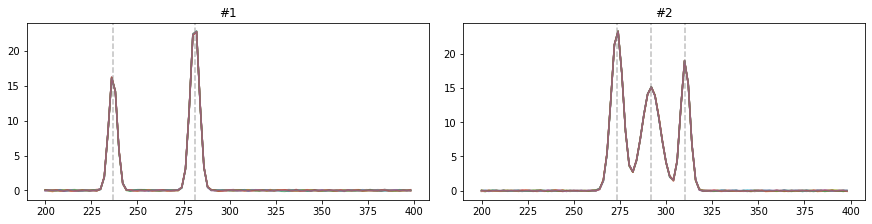

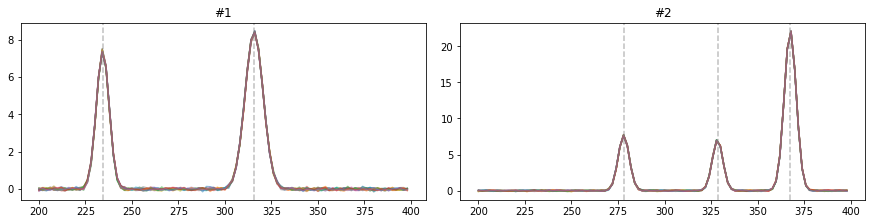

In [6]:
# list of wavelengths (x-values)
xval = [i for i in range(200, 400, 2)]

# number of spectra per peak number
nsets  = 1

# number of peaks in the spectrum
#peak_numbers = [2,3,4,5,6]
peak_numbers = [2,3]

# total number of datasets
tsets = nsets * len(peak_numbers)

# total number of inference runs (per run)
truns = nsets * len(peak_numbers)**2

# generate nruns sets of spectra
for r in range(conf['nruns']):
    print("Generating dataset {0} of {1}".format(r+1,conf['nruns']))
    
    ldata, lpeaks, lpeakdata  = [], [], []
    
    # create output directory for data
    out_dir = out_path + '/run_{0:02d}'.format(r+1)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
            
    for pn in peak_numbers:
        for i in range(nsets):
            df, peaks, df_peakinfo = dg.data_generator(xvalues=xval, nsamples=15, npeaks=pn)
            ldata.append(df)
            lpeaks.append(peaks)
            lpeakdata.append(df_peakinfo)
            
    # save data and peak information to disk
    for i in range(len(ldata)):
        ldata[i].to_csv(out_dir + '/dataset_{0:02d}.csv'.format(i+1), index=False)
        lpeakdata[i].to_csv(out_dir + '/peakdata_{0:02d}.csv'.format(i+1), index=False)
    dg.data_save(out_dir + '/peakinfo.csv', lpeaks)
    
    # plot datasets
    filen = out_dir + '/scenario_peaks'
    fig.plot_datasets(ldata, lpeaks, dims=(int(tsets/2),2), figure_size=(12,int(tsets*(1.8))), 
                                                        savefig='yes', fname=filen)
    #fig.plot_datasets(ldata, lpeaks, dims=(1,2), figure_size=(12,2), 
    #                                                    savefig='yes', fname=filen)

In [7]:
print("total number of multiple runs                    : {0}".format(conf['nruns']))
print("total number of peak numbers                     : {0}".format(len(peak_numbers)))
print("total number of datasets per peak number         : {0}".format(nsets))
print("total number of datasets per model               : {0}".format(tsets))
print("total number of inference runs (per single loop) : {0}".format(truns))

total number of multiple runs                    : 2
total number of peak numbers                     : 2
total number of datasets per peak number         : 1
total number of datasets per model               : 2
total number of inference runs (per single loop) : 4


# Load data, run inference, visualize, collect results and save 

In [8]:
# convert pandas data to numpy arrays
x_val = np.array(xval, dtype='float32')

In [9]:
# dataframe to hold multiple run results
#res_df = pd.DataFrame(columns=['r_hat','mcse','ess','bfmi','r2','waic',
#                                   'epsilon','epsilon_real','model','peaks'])
res_df = pd.DataFrame()

# run the whole loop of inference, posterior sampling, results collection and saving
for r in range(conf['nruns']):
    print("starting loop {0}/{1}".format(r+1,conf['nruns']))

    models, traces, lmodpeak = [], [], []

    # load datasets from disk
    data_dir = out_path + '/run_{0:02d}'.format(r+1)
    ldata, lpeaks, lpeakdata = dg.data_load(tsets, data_dir)

    # store dataset y-values in list
    cols = ldata[0].columns
    y_val = [ldata[i][cols].values for i in range(len(ldata))]

    # actual inference run number
    inf_run = 1

    for pn in peak_numbers:
        print("running {0}-peak model".format(pn))
        for i in range(len(ldata)):
            if conf['peak_info'] == 'yes':
                # Get the peak numbers from the list. If the actual peak number in the spectrum is 
                # lower than what the model is expecting, then expand the list to the expected size,
                # duplicating the existing peak mu values, else truncate the list (taking the peaks
                # with the highest amplitude).
                plist = sorted(lpeaks[i])
                if len(plist) < pn:
                    pl = sorted(np.resize(plist, (1,pn)).flatten())
                else:
                    # sort peak info dataframe on amplitude value 
                    l1 = lpeakdata[i].sort_values('amp', ascending=False)
                    # truncate list to expected peak number
                    pl = l1['mu'].values[:pn]

                model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=pn, 
                                          mu_peaks=pl, pmodel=conf['prior_model'])
            else:
                model_g = mdl.model_gauss(xvalues=x_val, observations=y_val[i], npeaks=pn,
                                          pmodel=conf['prior_model'])      
            models.append(model_g)

            with model_g:
                print("({6}:{2}/{3}) running inference on dataset #{0}/{1} [{4}-peak model:{5}-peak spectrum]"
                      .format(i+1,len(ldata),inf_run,truns,pn,len(plist),r+1))
                lmodpeak += [(pn,len(plist))]
                trace_g = pm.sample(conf['nsamples'], init=conf['init_mode'], cores=conf['ncores'])
                traces.append(trace_g)
                inf_run += 1

    # save model figure as image (once)
    if r == 0:
        img = pm.model_to_graphviz(models[0])
        img.render(filename=file_basename + '_model', format='png');

    # posterior predictive traces
    ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

    # collect the results, concat single run result to overall result 
    varnames = ['amp', 'mu', 'sigma', 'epsilon']
    lruns = ['{0}'.format(r+1) for i in range(truns)]
    df = res.get_results_summary(varnames, traces, ppc, y_val, epsilon_real=0.05, sets=tsets, 
                                 labels=lmodpeak, runlist=lruns)
    
    res_df = res_df.append(df, ignore_index=True)

starting loop 1/2
running 2-peak model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(1:1/4) running inference on dataset #1/2 [2-peak model:2-peak spectrum]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 437.28draws/s]
The acceptance probability does not match the target. It is 0.8958449305869077, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(1:2/4) running inference on dataset #2/2 [2-peak model:3-peak spectrum]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 325.39draws/s]
The acceptance probability does not match the target. It is 0.8955741144073821, but should be close to 0.8. Try to increase the number of tuning steps.


running 3-peak model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(1:3/4) running inference on dataset #1/2 [3-peak model:2-peak spectrum]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 367 divergences: 100%|██████████| 5000/5000 [10:31<00:00,  7.92draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6604044196921941, but should be close to 0.8. Try to increase the number of tuning steps.
There were 365 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(1:4/4) running inference on dataset #2/2 [3-peak model:3-peak spectrum]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 323.00draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8884144800031337, but should be close to 0.8. Try to increase the number of tuning steps.
/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 422.77it/s]
/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior pred

starting loop 2/2
running 2-peak model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(2:1/4) running inference on dataset #1/2 [2-peak model:2-peak spectrum]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 5 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 361.89draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9011046305549223, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(2:2/4) running inference on dataset #2/2 [2-peak model:3-peak spectrum]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 5 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 407.90draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


running 3-peak model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(2:3/4) running inference on dataset #1/2 [3-peak model:2-peak spectrum]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 141 divergences: 100%|██████████| 5000/5000 [10:51<00:00,  7.67draws/s]
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9265358458089041, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(2:4/4) running inference on dataset #2/2 [3-peak model:3-peak spectrum]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 346.17draws/s]
The acceptance probability does not match the target. It is 0.9104203029128781, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8872994067384139, but should be close to 0.8. Try to increase the number of tuning steps.
/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 430.17it/s]
/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/arviz/stats/stats.p

## Show results and save

In [10]:
res_df

,r_hat,mcse,ess,bfmi,r2,waic,epsilon,epsilon_real,run,model,peaks
0,1.000,0.000143,5253.142857,1.078875,0.997503,-526.254899,0.201115,0.05,1,2,2
1,1.000,0.004286,3119.428571,1.013069,0.677000,7745.353666,3.191229,0.05,1,2,3
2,1.621,2.059200,15.100000,0.474622,0.997496,3925.973716,0.125552,0.05,1,3,2
3,1.000,0.000000,4745.900000,1.056925,0.999861,-4067.989191,0.062094,0.05,1,3,3
4,1.000,0.000000,4806.428571,1.104407,0.999416,-4813.701880,0.048547,0.05,2,2,2
5,1.000,0.001429,4226.714286,1.059030,0.916939,4629.790777,1.127521,0.05,2,2,3
6,1.070,5.247500,870.300000,0.912413,0.999418,-4813.163904,0.048555,0.05,2,3,2
7,1.000,0.000000,5173.700000,1.077727,0.999822,-4650.473549,0.051208,0.05,2,3,3


In [11]:
# save results to .csv
res_df.to_csv(out_path + '/scenario_peaks_mruns.csv', index=False)

In [12]:
cnf.close(out_path)